Imports

In [1]:
import pathlib
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Define data directory filepaths and ensure they exist

In [2]:
data_directory = pathlib.Path('data_files/')
assert data_directory.exists(), f'Cannot find {data_directory} folder'

P1_data_filepath = pathlib.Path(data_directory, 'P1_data.csv')
assert P1_data_filepath.exists(), f'Cannot find {P1_data_filepath}'

P2_job_data_filepath = pathlib.Path(data_directory, 'P2_job_data.csv')
assert P2_job_data_filepath.exists(), f'Cannot find {P2_job_data_filepath}'

P2_setup_data_filepath = pathlib.Path(data_directory, 'P2_setup_data.csv')
assert P2_setup_data_filepath.exists(), f'Cannot find {P2_setup_data_filepath}'

P3_data_filepath = pathlib.Path(data_directory, 'P3_data.csv')
assert P3_data_filepath.exists(), f'Cannot find {P3_data_filepath}'

In [3]:
# Define API Switcher

def get_API_neighbor(schedule_list):

    neighbor_list = list(schedule_list)
    valid_indices = range(len(neighbor_list)-1)
    idx1 = random.choice(valid_indices)
    idx2 = idx1 + 1

    neighbor_list[idx2], neighbor_list[idx1] = neighbor_list[idx1], neighbor_list[idx2]

    return neighbor_list

In [4]:
# Define PI Switcher

def get_PI_neighbor(schedule_list):

    neighbor_list = list(schedule_list)
    valid_indices = list(range(len(neighbor_list)))
    idx1, idx2 = random.choices(valid_indices, k=2)

    neighbor_list[idx2], neighbor_list[idx1] = neighbor_list[idx1], neighbor_list[idx2]

    return neighbor_list

### Problem 1 - $1/s_{j}/\sum C_{j}$

Identify and implement a **static** dispatching rule to generate a good schedule for instance defined in the `P1_data.csv` file. Justify your choice of static dispatching rule.

<ins>Grading breakdown</ins>
- 15 pts - working algorithm that implements a static dispatching rule
- 5 pts - objective function computed correctly and printed to screen
- 5 pts - schedule quality meets or exceeds that of best schedule found from random generation of 10,000 schedules.

In [5]:
# Minimize sum of completion times given they have setup times
# I used a static rule where I combined the setup time and processing job in order to find the job that completes the fastest.
# Since all jobs have to be completed, by scheduling the fastest job first, the minimal sum of completion times can be found. Due to whatever rule in class we called it this is an optimal solution.

p1_data = pd.read_csv(P1_data_filepath)
p1_data = p1_data.set_index('j')
p1_data.head()

p1_data['cj'] = ( (p1_data['sj'] + p1_data['pj'] ) ) # Create new column for total time it takes for a job (setup and processing)

current_time = 0
scheduled_jobs = []
all_jobs = p1_data.index.to_list()
unscheduled_jobs = set(all_jobs) - set(scheduled_jobs)
unscheduled_job_filter = p1_data.index.isin(unscheduled_jobs)
unscheduled_job_data = p1_data[unscheduled_job_filter]

completion_times = {}


while unscheduled_jobs:
   
    selected_job = unscheduled_job_data['cj'].idxmin() # This picks the job that will complete the fastest
    current_time += unscheduled_job_data.loc[selected_job, 'cj']
    completion_times[selected_job] = current_time

    scheduled_jobs.append(selected_job)
    unscheduled_jobs = set(all_jobs) - set(scheduled_jobs)
    unscheduled_jobs = list(unscheduled_jobs)

    unscheduled_job_filter = p1_data.index.isin(unscheduled_jobs)
    unscheduled_job_data = p1_data[unscheduled_job_filter]

    print(f' -At time {current_time}, schedule job {selected_job}')

print('Minimized sum of all completion times is :',sum(completion_times.values()), 'units of time')
print('For a schedule of', scheduled_jobs)


 -At time 3.8000000000000003, schedule job 2
 -At time 9.9, schedule job 10
 -At time 16.4, schedule job 6
 -At time 23.0, schedule job 13
 -At time 30.0, schedule job 9
 -At time 37.1, schedule job 7
 -At time 45.5, schedule job 14
 -At time 54.1, schedule job 18
 -At time 62.900000000000006, schedule job 5
 -At time 72.0, schedule job 16
 -At time 81.3, schedule job 17
 -At time 90.89999999999999, schedule job 3
 -At time 100.8, schedule job 15
 -At time 111.3, schedule job 19
 -At time 122.5, schedule job 8
 -At time 133.7, schedule job 20
 -At time 145.1, schedule job 1
 -At time 156.79999999999998, schedule job 4
 -At time 168.49999999999997, schedule job 11
 -At time 181.19999999999996, schedule job 12
Minimized sum of all completion times is : 1646.7999999999997 units of time
For a schedule of [2, 10, 6, 13, 9, 7, 14, 18, 5, 16, 17, 3, 15, 19, 8, 20, 1, 4, 11, 12]


### Problem 2 - $1/s_{jk}/\sum C_{j}$

Implement a construction-improvement approach to solve the problem. Justify any choices you make when developing the approach. The job data is given in the file named `P2_job_data.csv`. The setup time data is given in the file named `P2_setup_data.csv`. Assume that the initial state of the machine is indicated by job 0. Thus, if the first job in the schedule is job $j$, a setup of length $s_{oj}$ is incurred before the first job can start.

<ins>Grading breakdown</ins>
- 15 pts - working construction algorithm
- 20 pts - working improvement algorithm
- 5 pts - objective function computed correctly and printed to screen
- 10 pts - schedule quality meets or exceeds that of best schedule found from random generation of 100,000 schedules.

In [6]:
# Minimize sum of completion times given they have setup times dependent on prior jobs and use construction improvement

p2_job_data = pd.read_csv(P2_job_data_filepath)
p2_job_data = p2_job_data.set_index('j')
p2_setup_data = pd.read_csv(P2_setup_data_filepath)
setup_times = p2_setup_data.set_index(
    ['j', 'k']
)['sjk'].to_dict()
pj2 = p2_job_data['pj'].to_dict()

all_jobs = p2_job_data.index.to_list()


In [7]:
# Define completion time calculator

def completion_time_calculator(schedule_list):

    current_time = 0
    calc_completion_times = {}
    previous_job = 0

    for job in schedule_list:
        setup_time = setup_times[previous_job, job]
        completion_time = current_time + setup_time + pj2[job] # This calculates the time the job finishes based on the setup time from the previoous job to this one and adds the processing time of the job
        #print('Current Time',current_time, 'setup_time',setup_times[previous_job, job], 'pj', pj[job])

        calc_completion_times[job] = completion_time

        current_time = completion_time
        #print(previous_job, job, setup_time, pj2[job])
        #print(job,(setup_time+pj2[job]) )
        previous_job = job
        

    return( sum(calc_completion_times.values()) )
    #return(calc_completion_times)

In [8]:
current_time = 0
previous_job = 0
scheduled_jobs = []

all_jobs = p2_job_data.index.to_list()

unscheduled_jobs = set(all_jobs) - set(scheduled_jobs)
unscheduled_job_filter = p2_job_data.index.isin(unscheduled_jobs)
unscheduled_job_data = p2_job_data[unscheduled_job_filter]

completion_times = {}

while unscheduled_jobs:

    unscheduled_jobs = set(all_jobs) - set(scheduled_jobs)
    unscheduled_job_filter = p2_job_data.index.isin(unscheduled_jobs)
    unscheduled_job_data = p2_job_data[unscheduled_job_filter]

    for job in range(1,len(p2_job_data)+1):
        setup_time = setup_times[previous_job, job]
        p2_job_data.loc[job,'sj'] = setup_time
    
    p2_job_data['runTime'] = p2_job_data['sj'] + p2_job_data['pj']

    unscheduled_job_filter = p2_job_data.index.isin(unscheduled_jobs)
    unscheduled_job_data = p2_job_data[unscheduled_job_filter]
    #print(unscheduled_job_data)
    selected_job = unscheduled_job_data['runTime'].idxmin() # This picks the job that will complete the fastest
    print(f' -At time {current_time}, schedule job {selected_job}')
    #print('Current Time',current_time, 'run time', unscheduled_job_data.loc[selected_job,'runTime'])
    run_time = unscheduled_job_data.loc[selected_job, 'runTime']

    current_time += run_time
    #print(setup_times[previous_job, job])
    completion_times[selected_job] = current_time

    scheduled_jobs.append(selected_job)
    previous_job = selected_job

    unscheduled_jobs = set(all_jobs) - set(scheduled_jobs)
    unscheduled_job_filter = p2_job_data.index.isin(unscheduled_jobs)
    unscheduled_job_data = p2_job_data[unscheduled_job_filter]

construction_time = completion_time_calculator(scheduled_jobs)
print('Minimum completion time is:', construction_time, 'units of time')
print('For a schedule of', scheduled_jobs)

 -At time 0, schedule job 17
 -At time 8.73, schedule job 3
 -At time 18.64, schedule job 10
 -At time 29.29, schedule job 6
 -At time 40.85, schedule job 4
 -At time 51.83, schedule job 13
 -At time 61.9, schedule job 9
 -At time 72.91, schedule job 18
 -At time 85.17999999999999, schedule job 20
 -At time 96.02, schedule job 2
 -At time 108.44999999999999, schedule job 5
 -At time 120.68999999999998, schedule job 8
 -At time 132.91, schedule job 7
 -At time 144.44, schedule job 15
 -At time 155.9, schedule job 11
 -At time 167.77, schedule job 16
 -At time 183.66000000000003, schedule job 14
 -At time 196.72000000000003, schedule job 1
 -At time 210.38000000000002, schedule job 19
 -At time 225.35000000000002, schedule job 12
Minimum completion time is: 2351.38 units of time
For a schedule of [17, 3, 10, 6, 4, 13, 9, 18, 20, 2, 5, 8, 7, 15, 11, 16, 14, 1, 19, 12]


In [9]:
# Run API switching for 1000000 nonimproving iterations.

np.random.seed(0)
max_ni_iterations = 1000000

incumbent_solution = (scheduled_jobs) # Setting this to all_jobs instead of scheduled_jobs will run the improvement algortihm for jobs if you start at 1 and run in order until 20
incumbent_completion_time = completion_time_calculator(incumbent_solution)

iteration = 0
count = 0
progress = []
while iteration < max_ni_iterations:
    iteration += 1
    count += 1
    
    neighbor = get_PI_neighbor(incumbent_solution)
    neighbor_completion_time = completion_time_calculator(neighbor)
    #print('incumbent_max_lateness:', incumbent_max_lateness)
    #print('neighbor_max_lateness:', neighbor_max_lateness)
    if neighbor_completion_time < incumbent_completion_time:
        incumbent_solution = neighbor
        incumbent_completion_time = neighbor_completion_time
        iteration = 0
    progress.append({'Iteration': count, 'Best': incumbent_completion_time})

print('Minimum completion time is:', incumbent_completion_time, 'units of time')
print('For a schedule of', incumbent_solution)

# Best solution I found by running this block many times was 2323.52 units of time
# For a schedule of [9, 17, 5, 3, 16, 13, 4, 6, 18, 2, 20, 11, 10, 15, 7, 14, 8, 19, 12, 1]

Minimum completion time is: 2351.38 units of time
For a schedule of [17, 3, 10, 6, 4, 13, 9, 18, 20, 2, 5, 8, 7, 15, 11, 16, 14, 1, 19, 12]


In [10]:
completion_time_calculator([9, 17, 5, 3, 16, 13, 4, 6, 18, 2, 20, 11, 10, 15, 7, 14, 8, 19, 12, 1])
# Proof that the mentioned best solution so far runs at this time.

2323.5200000000004

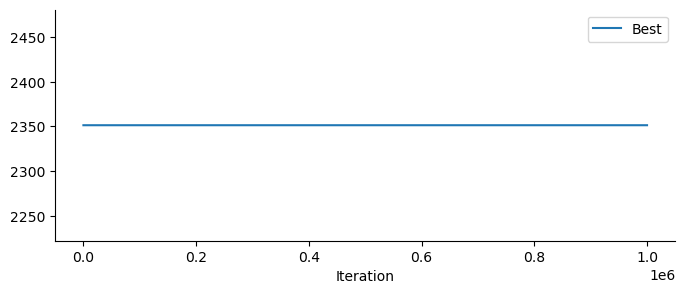

In [11]:
# Generate graph of trials

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

progress_df = pd.DataFrame(progress)
progress_df.plot(
    x='Iteration',
    y='Best',
    ax=ax,
)

ax.spines[['right', 'top']].set_visible(False)
plt.show()

### Problem 3 - $1/s_{j}, r_{j}/L_{max}$

Identify and implement a **dynamic** dispatching rule to generate a good schedule for instance defined in the `P3_data.csv` file. Justify your choice of dynamic dispatching rule.

<ins>Grading breakdown</ins>
- 15 pts - working algorithm that implements a dynamic dispatching rule
- 5 pts - objective function computed correctly and printed to screen
- 5 pts - schedule quality meets or exceeds that of best schedule found from random generation of 10,000 schedules.

In [12]:
p3_data = pd.read_csv(P3_data_filepath)
p3_data = p3_data.set_index('j')

In [17]:
# Minimize worst case lateness time given they have setup times and release times
# My method was to calculate the lateness of a job at any given time that would occur when it is done being setup and run
# By then choosing to run the job that would be the most late upon completiong at that time we should get a pretty good solution

current_time = 0
scheduled_jobs = []
all_jobs = p3_data.index.to_list()
lateness_times = {}
completion_times = {}

p3_data['cj'] = ( (p3_data['sj'] + p3_data['pj'] ) ) # Calculate time to setup and process job
p3_data['L'] = (current_time + (p3_data['cj'] - p3_data['dj'] )) # This calculates the lateness of the jobs based on current time

unscheduled_jobs = set(all_jobs) - set(scheduled_jobs)
unscheduled_job_filter = p3_data.index.isin(unscheduled_jobs)
unscheduled_job_data = p3_data[unscheduled_job_filter]


while unscheduled_jobs:

    time_filter = unscheduled_job_data['rj'] <= current_time
           

    if len(unscheduled_job_data[time_filter]) == 0:
        
        print(f' -At time {current_time}, there are no jobs to schedule')
        current_time += p3_data['rj'].min()

    else:

        p3_data['L'] = (current_time + (p3_data['cj'] - p3_data['dj'] )) # This calculates the lateness of the jobs based on current time
        selected_job = unscheduled_job_data['L'].idxmax() # This picks the job that will be the most late and runs it.
        current_time += unscheduled_job_data.loc[selected_job, 'cj']
        completion_times[selected_job] = current_time
        lateness_times[selected_job] = current_time - p3_data.loc[selected_job, 'dj']

        scheduled_jobs.append(selected_job)
        unscheduled_jobs = set(all_jobs) - set(scheduled_jobs)
        unscheduled_jobs = list(unscheduled_jobs)

        unscheduled_job_filter = p3_data.index.isin(unscheduled_jobs)
        unscheduled_job_data = p3_data[unscheduled_job_filter]

        print(f' -At time {current_time}, schedule job {selected_job}')

#print(lateness_times)
print('Maximum Lateness is:', max(lateness_times.values()), 'units of time'  )
print('For a schedule of:', scheduled_jobs)
#print(lateness_times)

 -At time 0, there are no jobs to schedule
 -At time 12.6, schedule job 18
 -At time 19.1, schedule job 6
 -At time 25.200000000000003, schedule job 10
 -At time 35.1, schedule job 15
 -At time 46.3, schedule job 8
 -At time 55.599999999999994, schedule job 17
 -At time 66.1, schedule job 19
 -At time 73.1, schedule job 9
 -At time 76.89999999999999, schedule job 2
 -At time 83.99999999999999, schedule job 7
 -At time 93.59999999999998, schedule job 3
 -At time 102.69999999999999, schedule job 16
 -At time 111.1, schedule job 14
 -At time 117.69999999999999, schedule job 13
 -At time 129.39999999999998, schedule job 4
 -At time 140.79999999999998, schedule job 1
 -At time 153.49999999999997, schedule job 12
 -At time 164.69999999999996, schedule job 20
 -At time 176.39999999999995, schedule job 11
 -At time 185.19999999999996, schedule job 5
Maximum Lateness is: 99.39999999999995 units of time
For a schedule of: [18, 6, 10, 15, 8, 17, 19, 9, 2, 7, 3, 16, 14, 13, 4, 1, 12, 20, 11, 5]


In [14]:
# Define a function to compute the max lateness times

def compute_max_lateness_time(schedule_list):

    current_time = 0
    lateness_times = {}
    
    for job in schedule_list:
        
        completion_time = current_time + cj[job]
        lateness_times[job] = completion_time  - dj[job]
        current_time = completion_time
        #print(lateness_times)
        
    return max(lateness_times.values())


In [15]:
# Run API switching for 10000 nonimproving iterations.
cj = p3_data['cj'].to_dict()
dj = p3_data['dj'].to_dict()

np.random.seed(0)
max_ni_iterations = 10000

incumbent_solution = list(lateness_times.keys())
incumbent_max_lateness = compute_max_lateness_time(incumbent_solution)

iteration = 0
count = 0
progress = []
while iteration < max_ni_iterations:
    iteration += 1
    count += 1
    
    neighbor = get_API_neighbor(incumbent_solution)
    neighbor_max_lateness= compute_max_lateness_time(neighbor)
    #print('incumbent_max_lateness:', incumbent_max_lateness)
    #print('neighbor_max_lateness:', neighbor_max_lateness)
    if neighbor_max_lateness < incumbent_max_lateness:
        incumbent_solution = neighbor
        incumbent_max_lateness = neighbor_max_lateness
        iteration = 0
    progress.append({'Iteration': count, 'Best': incumbent_max_lateness})



print(' Maximum Lateness is:', incumbent_max_lateness, 'units of time'  )
print('For a schedule of', scheduled_jobs)
#print(lateness_times)

# This API switch shows that after 2000 iterations our solution does not improve at all
# All that work for nuthin :(

 Maximum Lateness is: 95.39999999999992 units of time
For a schedule of [18, 6, 10, 15, 8, 17, 19, 9, 2, 7, 3, 16, 14, 13, 4, 1, 12, 20, 11, 5]


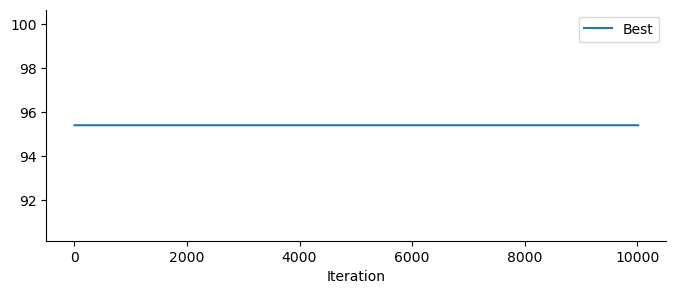

In [16]:
# Generate graph of trials just to check

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

progress_df = pd.DataFrame(progress)
progress_df.plot(
    x='Iteration',
    y='Best',
    ax=ax,
)

ax.spines[['right', 'top']].set_visible(False)
plt.show()